# Описание

В этом задании  стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)



Для решения этой задачи мы воспользуемся **transfer learning и finetuning**. И воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.


## Выбор сети для обучения

В этом задании мы возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями.

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника

In [2]:
! pip install git+https://github.com/DavidDoukhan/keras-vggface.git

  Cloning https://github.com/DavidDoukhan/keras-vggface.git to /tmp/pip-req-build-xorv3pw8
  Running command git clone -q https://github.com/DavidDoukhan/keras-vggface.git /tmp/pip-req-build-xorv3pw8
     |████████████████████████████████| 50 kB 2.0 MB/s 
  Created wheel for keras-vggface: filename=keras_vggface-0.6_vddk_0.1-py3-none-any.whl size=8455 sha256=4100d4b633733eb78e5cba9c6618271dae3d347b992c72148142dcc9670fc666
  Stored in directory: /tmp/pip-ephem-wheel-cache-cthd5of4/wheels/99/0f/5f/e23a38bab21ffcc7d380bd2a6fef9cf285dc22e04cb61d9e67
Failed to build keras-vggface
    Running setup.py install for keras-vggface ... done
  DEPRECATION: keras-vggface was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [3]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Т.к. мы решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

Модель находится по адресу: https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO . Загрузим модель:

In [5]:
! pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
output = 'resnet50face.h5'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO
To: /content/resnet50face.h5
100%|██████████| 166M/166M [00:00<00:00, 191MB/s]


'resnet50face.h5'

In [6]:
from tensorflow.keras.models import load_model
vggface_model = load_model("resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet.

In [7]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [8]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2021-11-11 11:32:37--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 172.67.214.206, 104.21.83.52, 2606:4700:3033::6815:5334, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|172.67.214.206|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg [following]
--2021-11-11 11:32:37--  https://img.joinfo.com/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.com (img.joinfo.com)... 172.67.147.235, 104.21.28.245, 2606:4700:3033::ac43:93eb, ...
Connecting to img.joinfo.com (img.joinfo.com)|172.67.147.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43154 (42K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  42.14K  --.-KB/s    in 0.003s  

2021-11-11 11:32:37 (13.9 MB/s) - ‘brad_pitt.jpg’ saved [43154/43154]



После загрузки запустим полный пример из репозитория:

1351680/1346516 [==============================] - 0s 0us/step


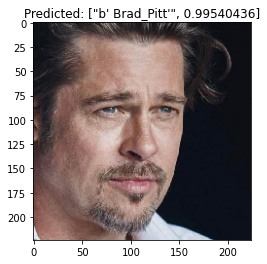

In [9]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2.

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных
Мы убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можем перейти к загрузке наших данных.

In [10]:
from pathlib import Path
from collections import Counter

In [11]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
100%|██████████| 107M/107M [00:00<00:00, 231MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 98.3MB/s]


'train_val_split_utk.csv'

In [12]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['8_1_2_20161219194234250.jpg.chip.jpg', '49_0_0_20170111181750448.jpg.chip.jpg', '60_0_3_20170117175443809.jpg.chip.jpg']


In [13]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg


,img_name,age,race,gender
0,28_0_4_20170117180230348.jpg.chip.jpg,0.241379,4,0
1,54_0_3_20170117185818497.jpg.chip.jpg,0.465517,3,0
2,48_0_0_20170117160523895.jpg.chip.jpg,0.413793,0,0
3,5_1_0_20170104202352685.jpg.chip.jpg,0.043103,0,1
4,26_1_1_20170113011845176.jpg.chip.jpg,0.224138,1,1


In [14]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [15]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

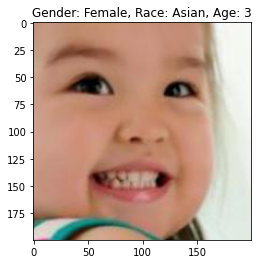

In [16]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


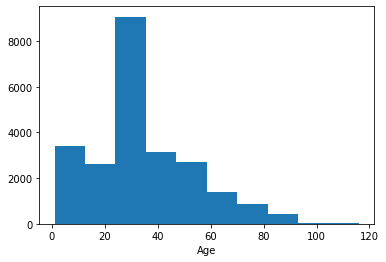

In [17]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

##  Создание генератора данных для модели предсказания пола.
Предподготовка закончена. Мы начнем с создания модели предсказания пола. В этом задании вы должны реализовать генератор данных необходимый для последущего обучения модели. Мы воспользуемся `tensorflow.keras.preprocessing.image.ImageDataGenerator`

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    
    x = image.img_to_array(image_)
    x = np.expand_dims(x, axis=0)
    preprocessed = utils.preprocess_input(image_, version=2) 
    
    #
    return preprocessed


image_gen = ImageDataGenerator(preprocessing_function = preprocess_input_facenet)





In [19]:
df_train.head()

,img_name,age,race,gender,is_train
0,28_0_4_20170117180230348.jpg.chip.jpg,0.241379,4,0,1
1,54_0_3_20170117185818497.jpg.chip.jpg,0.465517,3,0,1
2,48_0_0_20170117160523895.jpg.chip.jpg,0.413793,0,0,1
4,26_1_1_20170113011845176.jpg.chip.jpg,0.224138,1,1,1
5,35_1_2_20170104173050489.jpg.chip.jpg,0.301724,2,1,1


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224

image_gen = ImageDataGenerator(preprocessing_function = preprocess_input_facenet)
train_generator = image_gen.flow_from_dataframe(dataframe = df_train, x_col='img_name', y_col='gender', class_mode = "binary", directory=str(data_folder),shuffle=True, batch_size=BATCH_SIZE, target_size = (IMAGE_SIZE,IMAGE_SIZE)) 




val_generator = image_gen.flow_from_dataframe(dataframe = df_val, x_col='img_name', y_col='gender', class_mode = "binary", directory=str(data_folder), shuffle=False, batch_size=BATCH_SIZE, target_size = (IMAGE_SIZE,IMAGE_SIZE))







Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


In [21]:
sample_images, sample_labels = next(val_generator)
assert sample_images.shape == (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), "Неправильный размер батча"
assert sample_labels.shape == (BATCH_SIZE,), "Неправильный размер меток класса"
assert list(sorted(np.unique(sample_labels))) == [0., 1.], "Ожидаемые классы 0 и 1"
print("Simple tests passed")

Simple tests passed


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Male


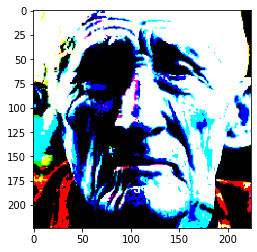

In [22]:
plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])


In [23]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

153.5047 -131.0912


Реализуем функцию `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.

Female


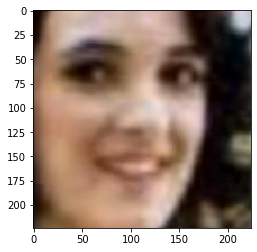

In [24]:
from keras import backend as K

def deprocess_image(vggface_image):
  image = np.copy(vggface_image)
  image[..., 0] += 91.4953
  image[..., 1] += 103.8827
  image[..., 2] += 131.0912
  image = image[..., ::-1]
  image = np.uint8(image)
  return image


plt.imshow(deprocess_image(sample_images[5]))
print(gender_mapping[int(sample_labels[5])])

##  Обучение модели предсказания пола

In [25]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                             

In [26]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [87]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [29]:
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  175


In [30]:
# < YOUR CODE STARTS HERE >
# from google.colab import drive

# drive.mount('/content/drive/')

from pathlib import Path
path = Path("/content/drive/My Drive/Skillbox/model_gender")
path.mkdir(exist_ok=True) # создаем папку на диске
cpt_filename = "checkpoint_best.h5"  
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

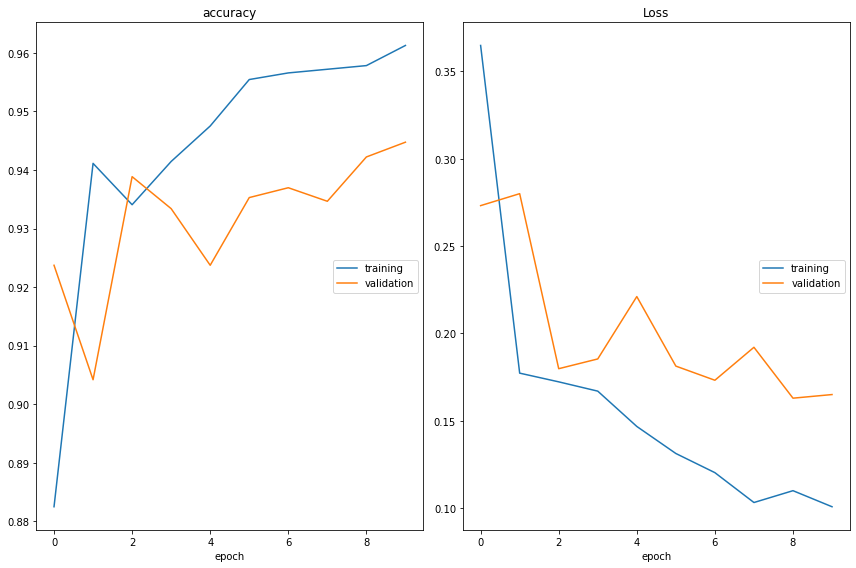

accuracy
	training         	 (min:    0.882, max:    0.961, cur:    0.961)
	validation       	 (min:    0.904, max:    0.945, cur:    0.945)
Loss
	training         	 (min:    0.101, max:    0.365, cur:    0.101)
	validation       	 (min:    0.163, max:    0.280, cur:    0.165)

Epoch 00010: accuracy improved from 0.95781 to 0.96125, saving model to /content/drive/My Drive/Skillbox/model_gender/checkpoint_best.h5
25/25 [==============================] - 20s 808ms/step - loss: 0.1008 - accuracy: 0.9613 - val_loss: 0.1650 - val_accuracy: 0.9447


In [31]:
# Обучение модели предсказания пола
from livelossplot.tf_keras import PlotLossesCallback
base_model.trainable = True
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=25,
    validation_data=val_generator,
    callbacks=[PlotLossesCallback(),checkpoint])

In [ ]:

! ls "/content/drive/My Drive/Skillbox/model_gender/"

checkpoint_best.h5


In [32]:
model_gender = load_model("/content/drive/My Drive/Skillbox/model_gender/checkpoint_best.h5")
loss, acc = model_gender.evaluate(val_generator)
if acc < 0.9:
    print("Please, try harder!")
else:
    if acc >= 0.94:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 11s 272ms/step - loss: 0.1650 - accuracy: 0.9447
Well done!


In [33]:
#вспомогательный код
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

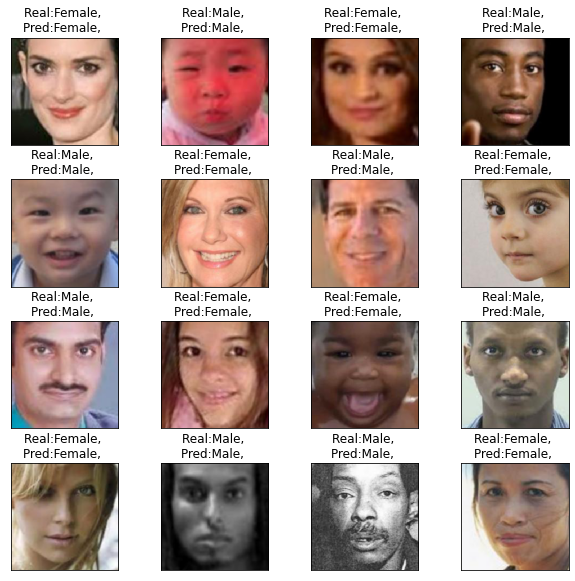

In [34]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##  Обучение модели предсказания расы

In [ ]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [ ]:

train_generator = image_gen.flow_from_dataframe(dataframe = df_train, x_col='img_name', y_col='race', class_mode = "sparse", \
                                                  directory=str(data_folder), shuffle=False, batch_size=BATCH_SIZE, target_size = (IMAGE_SIZE,IMAGE_SIZE))


val_generator = image_gen.flow_from_dataframe(dataframe = df_val, x_col='img_name', y_col='race', class_mode = "sparse",\
                                                directory=str(data_folder), shuffle=False, batch_size=BATCH_SIZE, target_size = (IMAGE_SIZE,IMAGE_SIZE))

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


In [ ]:
from pathlib import Path
path = Path("/content/drive/My Drive/Skillbox/model_race")
path.mkdir(exist_ok=True) # создаем папку на диске
cpt_filename = "checkpoint_best.h5"  
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Обучение модели предсказания расы
base_model.trainable = True
fine_tune_at = 150
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

loss = tf.keras.losses.SparseCategoricalCrossentropy()

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=loss,
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=25,
    validation_data=val_generator,
    callbacks=[checkpoint])

Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 0.5301 - sparse_categorical_accuracy: 0.8353
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.86111, saving model to /content/drive/My Drive/Skillbox/model_race/checkpoint_best.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


25/25 [==============================] - 55s 2s/step - loss: 0.5301 - sparse_categorical_accuracy: 0.8353 - val_loss: 0.5623 - val_sparse_categorical_accuracy: 0.8611
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 0.3099 - sparse_categorical_accuracy: 0.8984
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.86111
25/25 [==============================] - 49s 2s/step - loss: 0.3099 - sparse_categorical_accuracy: 0.8984 - val_loss: 0.5648 - val_sparse_categorical_accuracy: 0.8489
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 0.2775 - sparse_categorical_accuracy: 0.9072
Epoch 00003: val_sparse_categorical_accuracy improved from 0.86111 to 0.86846, saving model to /content/drive/My Drive/Skillbox/model_race/checkpoint_best.h5
25/25 [==============================] - 51s 2s/step - loss: 0.2775 - sparse_categorical_accuracy: 0.9072 - val_loss: 0.5269 - val_sparse_categorical_accuracy: 0.8685
Epoch 4/10
25/25 [=======================

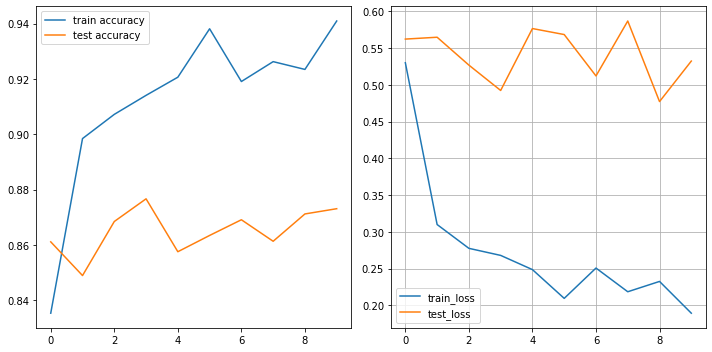

In [ ]:

def show_progress(history: dict):
    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)    
    plt.plot(history["sparse_categorical_accuracy"],label='train accuracy')
    plt.plot(history["val_sparse_categorical_accuracy"], label='test accuracy')
    ax2 = plt.subplot(1,2,2)
    plt.plot(history["loss"],label='train_loss')
    plt.plot(history["val_loss"],label='test_loss')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.grid()
    plt.tight_layout()
    plt.show()
show_progress(history.history)

In [ ]:
model_race = load_model("/content/drive/My Drive/Skillbox/model_race/checkpoint_best.h5")
loss, acc = model_race.evaluate(val_generator)
if acc < 0.8:
    print("Please, try harder!")
else:
    if acc >= 0.85:
        print("Well done!")
    else:
        print("Very good! Can you improve accuracy?")

38/38 [==============================] - 28s 718ms/step - loss: 0.4924 - sparse_categorical_accuracy: 0.8767
Well done!


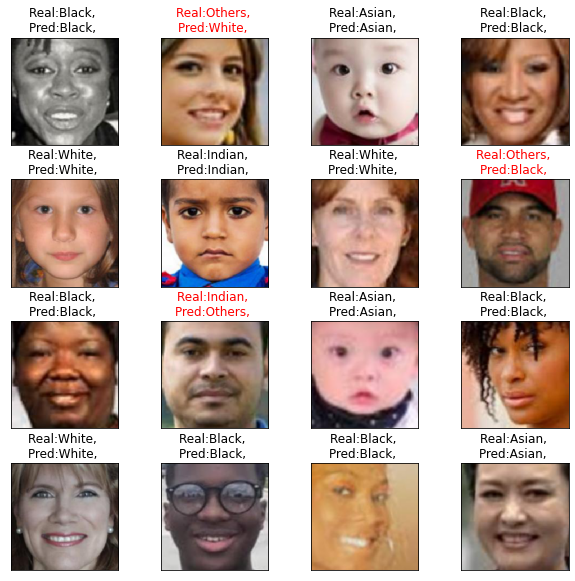

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Multitask learning



Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

In [41]:
vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

In [ ]:
df_train['race'] = np.asarray(df_train['race']).astype(np.float32)
df_train['gender'] = np.asarray(df_train['gender']).astype(np.float32)
df_val['race'] = np.asarray(df_val['race']).astype(np.float32)
df_val['gender'] = np.asarray(df_val['gender']).astype(np.float32)

In [59]:
model_base = tf.keras.Sequential([
  base_model, tf.keras.layers.Dense(1024, activation='relu')])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_2 (Functional)        (None, 2048)              23561152  
                                                                 
 dense_12 (Dense)            (None, 1024)              2098176   
                                                                 
Total params: 25,659,328
Trainable params: 2,098,176
Non-trainable params: 23,561,152
_________________________________________________________________


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_11 (Sequential)     (None, 2048)         27757504    ['input_18[0][0]']               
                                                                                                  
 gender (Dense)                 (None, 1)            2049        ['sequential_11[0][0]']          
                                                                                                  
 race (Dense)                   (None, 5)            10245       ['sequential_11[0][0]']    

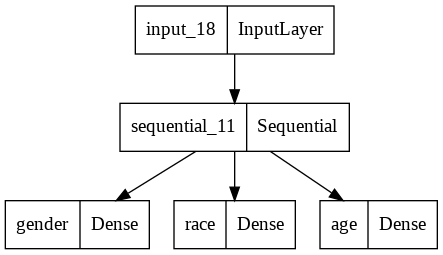

In [74]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model


input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))


model_base = tf.keras.Sequential([
  base_model, tf.keras.layers.Dense(2048, activation='relu')])

x = model_base(input_layer)

gender_output = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(x)
race_output = tf.keras.layers.Dense(5, activation='softmax', name='race')(x)
age_output = tf.keras.layers.Dense(1, name='age')(x)

model = tf.keras.Model(inputs=input_layer,
                    outputs=[gender_output, race_output, age_output])

model.summary()
plot_model(model)


In [75]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [76]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
def split_outputs(generator):
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1].astype("float32"), 3, axis=1)
        labels = [labels[0].reshape((len(labels[0]),)),
                  labels[1].reshape((len(labels[1]),)),
                  labels[2].reshape((len(labels[2]),))]
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


А теперь перейдем к обучению:

In [69]:
!pip install keras_applications
from livelossplot import PlotLossesKeras

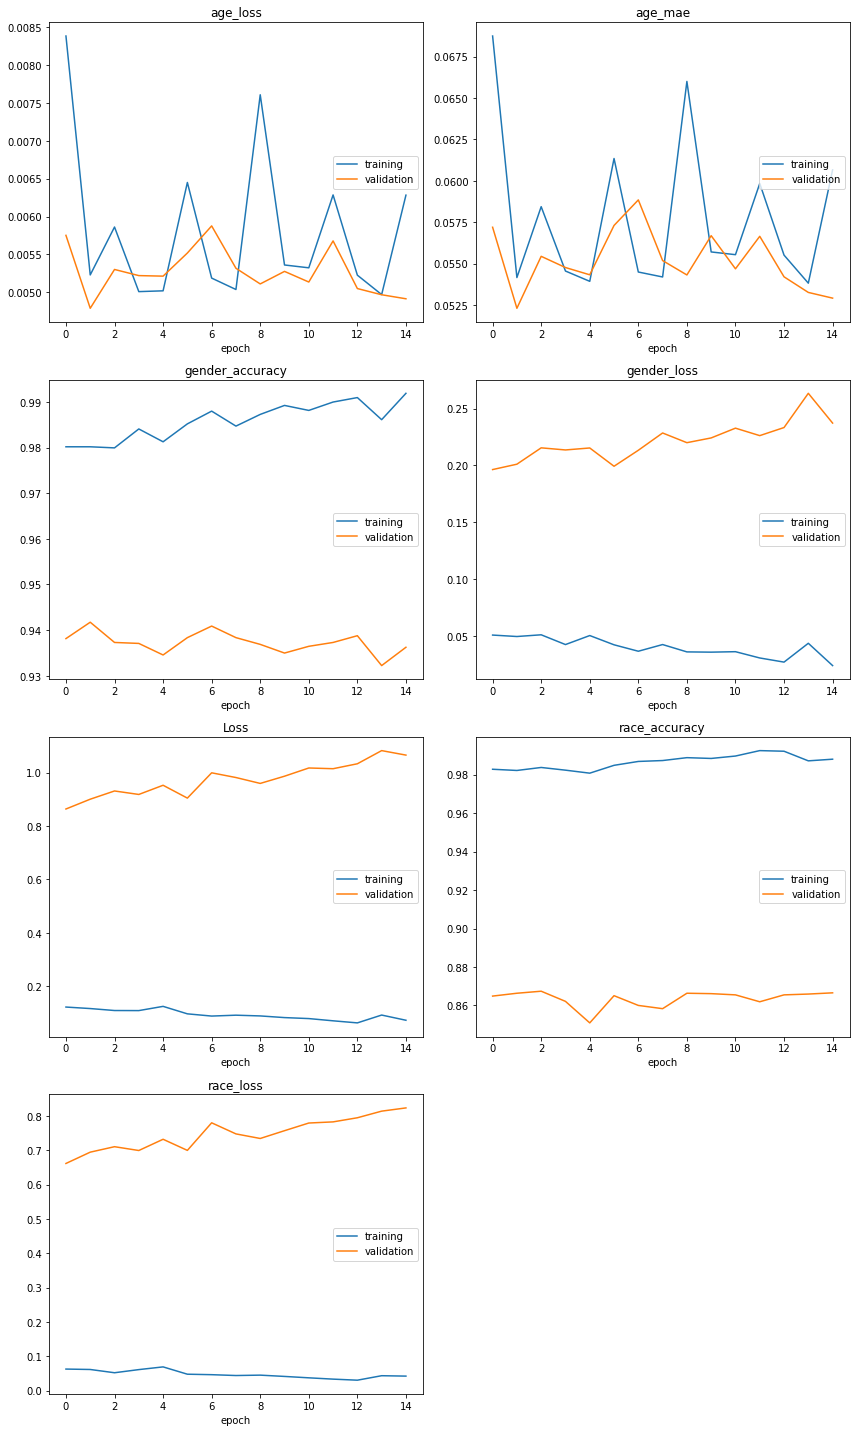

age_loss
	training         	 (min:    0.005, max:    0.008, cur:    0.006)
	validation       	 (min:    0.005, max:    0.006, cur:    0.005)
age_mae
	training         	 (min:    0.054, max:    0.069, cur:    0.061)
	validation       	 (min:    0.052, max:    0.059, cur:    0.053)
gender_accuracy
	training         	 (min:    0.980, max:    0.992, cur:    0.992)
	validation       	 (min:    0.932, max:    0.942, cur:    0.936)
gender_loss
	training         	 (min:    0.024, max:    0.051, cur:    0.024)
	validation       	 (min:    0.196, max:    0.263, cur:    0.237)
Loss
	training         	 (min:    0.062, max:    0.124, cur:    0.072)
	validation       	 (min:    0.864, max:    1.082, cur:    1.066)
race_accuracy
	training         	 (min:    0.981, max:    0.993, cur:    0.988)
	validation       	 (min:    0.851, max:    0.867, cur:    0.867)
race_loss
	training         	 (min:    0.030, max:    0.069, cur:    0.042)
	validation       	 (min:    0.662, max:    0.824, cur:    0.824)

E

In [84]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # вы можете выбрать другую скорость обучения для вашей модели


model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'accuracy', 'age': 'mae'})
path = Path("/content/drive/My Drive/Skillbox/model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min')

model.fit(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
                    callbacks=[PlotLossesKeras(), checkpoint], steps_per_epoch=50, 
                    validation_steps= len(df_val) // BATCH_SIZE)

In [88]:
! ls "/content/drive/My Drive/Skillbox/model_multitask/"

checkpoint_best.h5


In [94]:
model_multitask = load_model("/content/drive/My Drive/Skillbox/model_multitask/checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
37/37 [==============================] - 11s 290ms/step - loss: 1.0671 - gender_loss: 0.2347 - race_loss: 0.8275 - age_loss: 0.0049 - gender_accuracy: 0.9369 - race_accuracy: 0.8663 - age_mae: 0.0529
Well done!


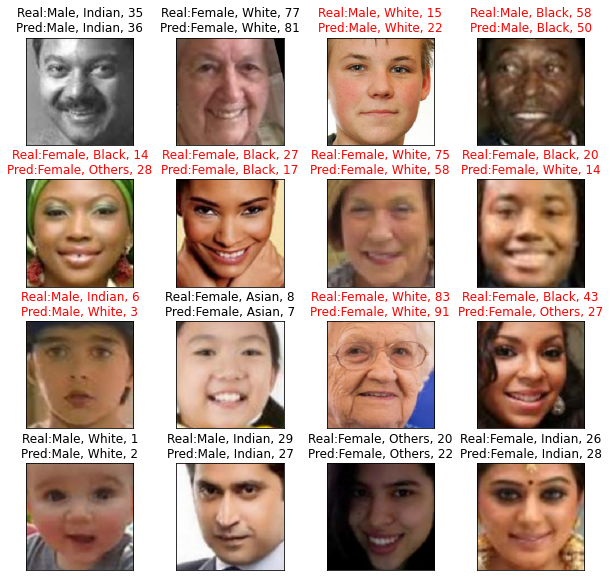

In [95]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )

# Заключение 

Мы получили достаточно хорошие значения в рамках задания, но эту модель можно значительно улучшить, я бы попробовал увеличить кол-во эпох в обучении и использовать аугментация, для снижения переобучения модели